In [2]:
import torch

In [3]:
import torch.nn as nn

In [4]:
import torch.nn.functional as F

In [5]:
import random

In [6]:
from collections import deque

In [7]:
from torch.distributions import Categorical

In [8]:
import numpy as np
np.bool8 = np.bool_


In [9]:
import gym

In [10]:
import os

In [11]:
import copy

In [12]:
import matplotlib.pyplot as plt

In [13]:
import seaborn as sns

In [14]:
class ActorSoftmax(nn.Module):
    
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(ActorSoftmax,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,output_dim)
    
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.fc3(x),dim=1)
        return probs

In [15]:
class Critic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Critic, self).__init__()
        assert output_dim == 1  # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [16]:
class ReplayBufferQue:
    
    def __init__(self,capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    
    def push(self,transitions):
        self.buffer.append(transitions)
    
    def sample(self,batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.deque)
        
        if sequential:
            rand = random.randint(0,len(self.buffer)-batch_size)
            batch = [self.buffer[i] for i in range(rand,rand+batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer,batch_size)
            return zip(*batch)
    
    def clear(self):
        self.buffer.clear()
    
    def __len__(self):
        return len(self.buffer)

In [17]:
class PGReplay(ReplayBufferQue):
    def __init__(self):
        self.buffer = deque()

    def sample(self):
        batch = list(self.buffer)
        return zip(*batch)

In [18]:
class Agent:
    
    def __init__(self,cfg) -> None:
        self.gamma = cfg.gamma
        self.device = torch.device(cfg.device)
        self.actor = ActorSoftmax(cfg.n_states,cfg.n_actions,
                                 hidden_dim=cfg.actor_hidden_dim).to(self.device)
        self.critic = Critic(cfg.n_states,1,hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.memory = PGReplay()
        self.k_epochs = cfg.k_epochs
        self.eps_clip = cfg.eps_clip
        self.entropy_coef = cfg.entropy_coef
        self.sample_count = 0
        self.update_freq = cfg.update_freq
    
    def sample_action(self,state):
        self.sample_count += 1
        state = torch.tensor(state,device=self.device,dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        return action.detach().cpu().numpy().item()
    
    
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state,
                            device=self.device,
                            dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()
    
    def update(self):
        if self.sample_count % self.update_freq != 0:
            return
        old_states,old_actions,old_log_probs,old_rewards,old_dones = \
        self.memory.sample()
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards),
                               reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0,discounted_sum)
        
        returns = torch.tensor(returns,device=self.device,dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
        
        for _ in range(self.k_epochs):
            values = self.critic(old_states)
            advantage = returns - values.detach()
            probs = self.actor(old_states)
            dist = Categorical(probs)
            new_probs = dist.log_prob(old_actions)
            ratio = torch.exp(new_probs - old_log_probs)
            
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps_clip,1+self.eps_clip) * advantage
            
            actor_loss = -torch.min(surr1,surr2).mean() + self.entropy_coef * dist.entropy().mean()
            
            critic_loss = (returns - values).pow(2).mean()
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        
        self.memory.clear()
        

In [19]:
def train(cfg,env,agent):
    print('begin to train')
    rewards = []
    steps = []
    best_ep_reward = 0
    output_agent = None
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        ep_step = 0
        state, _ = env.reset()
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)
            next_state,reward,terminated,truncated,_ = env.step(action)
            env.render()
            agent.memory.push((state,action,agent.log_probs,reward,terminated))
            state =  next_state
            agent.update()
            ep_reward += reward
            if terminated:
                break
        
        if (i_ep + 1) % cfg.eval_per_episode == 0:
            sum_eval_reward = 0
            for _ in range(cfg.eval_eps):
                eval_ep_reward = 0
                state, _ = env.reset()
                for _ in range(cfg.max_steps):
                    action = agent.predict_action(state)
                    next_state,reward,terminated,truncated,_ = env.step(action)
                    state = next_state
                    eval_ep_reward += reward
                    if terminated:
                        break
                sum_eval_reward += eval_ep_reward
            
            mean_eval_reward = sum_eval_reward / cfg.eval_eps
            
            if mean_eval_reward >= best_ep_reward:
                best_ep_reward = mean_eval_reward
                output_agent = copy.deepcopy(agent)
                print(f"回合：{i_ep + 1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}，更新模型！")
            else:
                print(f"回合：{i_ep + 1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}")
            
        steps.append(ep_step)
        rewards.append(ep_reward)
        
    print('finished')
    env.close()
    return output_agent, {'rewards': rewards}

In [20]:
def test(cfg, env, agent):
    print("开始测试！")
    rewards = []
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0
        ep_step = 0
        state, _ = env.reset()  # 修改为符合gym 0.26的接口
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.predict_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)  # 注意这里的返回值
            # 可视化环境
            env.render()  # 添加这一行
            state = next_state
            ep_reward += reward
            if terminated:  # 这里检查是否结束
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep + 1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards': rewards}

In [21]:
def all_seed(env, seed=1):
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

In [22]:

def env_agent_config(cfg):
    # env = gym.make(cfg.env_name)
    env = gym.make(cfg.env_name, render_mode="human")  # 或 "rgb_array"
    all_seed(env, seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)
    agent = Agent(cfg)
    return env, agent

In [23]:
class Config:
    def __init__(self) -> None:
        self.env_name = "CartPole-v1"
        self.new_step_api = False
        self.algo_name = "PPO"
        self.mode = "train"
        self.seed = 1
        self.device = "cpu"
        self.train_eps = 200
        self.test_eps = 20
        self.max_steps = 200
        self.eval_eps = 5
        self.eval_per_episode = 10
        self.gamma = 0.99
        self.k_epochs = 4
        self.actor_lr = 0.0003
        self.critic_lr = 0.0003
        self.eps_clip = 0.2
        self.entropy_coef = 0.01
        self.update_freq = 100
        self.actor_hidden_dim = 256
        self.critic_hidden_dim = 256


In [24]:
def smooth(data, weight=0.9):
    last = data[0]
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [25]:
def plot_rewards(rewards, cfg, tag='train'):
    sns.set()
    plt.figure()
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

状态空间维度：4，动作空间维度：2
begin to train


2025-03-02 13:08:10.558 python[39583:37960217] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-02 13:08:10.558 python[39583:37960217] +[IMKInputSession subclass]: chose IMKInputSession_Modern


回合：10/200，奖励：72.00，评估奖励：23.60，最佳评估奖励：23.60，更新模型！
回合：20/200，奖励：25.00，评估奖励：33.60，最佳评估奖励：33.60，更新模型！
回合：30/200，奖励：19.00，评估奖励：39.20，最佳评估奖励：39.20，更新模型！
回合：40/200，奖励：34.00，评估奖励：47.00，最佳评估奖励：47.00，更新模型！
回合：50/200，奖励：21.00，评估奖励：36.40，最佳评估奖励：47.00
回合：60/200，奖励：30.00，评估奖励：34.80，最佳评估奖励：47.00
回合：70/200，奖励：52.00，评估奖励：39.00，最佳评估奖励：47.00
回合：80/200，奖励：31.00，评估奖励：80.20，最佳评估奖励：80.20，更新模型！
回合：90/200，奖励：114.00，评估奖励：60.20，最佳评估奖励：80.20
回合：100/200，奖励：122.00，评估奖励：104.40，最佳评估奖励：104.40，更新模型！
回合：110/200，奖励：94.00，评估奖励：158.40，最佳评估奖励：158.40，更新模型！
回合：120/200，奖励：187.00，评估奖励：149.20，最佳评估奖励：158.40
回合：130/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：140/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：150/200，奖励：170.00，评估奖励：157.20，最佳评估奖励：200.00
回合：160/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：170/200，奖励：179.00，评估奖励：171.20，最佳评估奖励：200.00
回合：180/200，奖励：138.00，评估奖励：128.60，最佳评估奖励：200.00
回合：190/200，奖励：124.00，评估奖励：124.40，最佳评估奖励：200.00
回合：200/200，奖励：103.00，评估奖励：116.40，最佳评估奖励：200.00
finished
开始测试！


error: display Surface quit

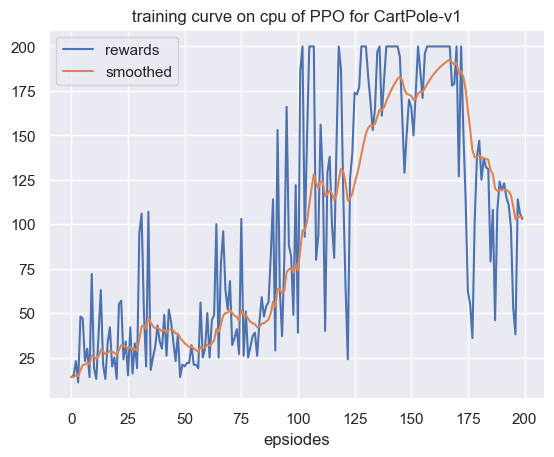

In [26]:
cfg = Config()
env, agent = env_agent_config(cfg)
best_agent, res_dic = train(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="train")
res_dic = test(cfg, env, best_agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")